# Classificação de Dataset Moons sem Data Re-uploading
Neste notebook, abordamos o dataset 'Moons', que apresenta uma complexidade maior de separabilidade em comparação a datasets lineares simples. Para lidar com essa característica, aumentamos a capacidade do modelo variacional, mas sem a tecnica de Re-Uploading

In [1]:
import pennylane as qml
from pennylane import AdamOptimizer
import pennylane.numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

## Importação das Bibliotecas

### Configuração de Hiperparâmetros e Estrutura
Para este problema, utilizei a mesma configuração do notebook com reupload mas dessa vez apenas modificando oembedding para fora do loop de layer

In [ ]:
n_qubits = 2
n_layers = 6
shape_weights = (n_layers, n_qubits, 3)
weights_init = np.random.uniform(low=0, high=2 * np.pi, size=shape_weights, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)
dev = qml.device("default.qubit", wires=n_qubits)


In [ ]:
opt = AdamOptimizer(0.01)

## Definição do Otimizador

Utilizamos o otimizador Adam com learning rate de 0.01 para atualização dos pesos do circuito.

### Circuito Quântico e Estratégia de Embedding
Diferentemente da versão com Re-uploading, aqui o `AngleEmbedding` é inserido **fora** do loop de camadas, sendo executado apenas uma vez no início do circuito.
- **Sem Data Re-uploading:** Os dados são encodados apenas uma vez, o que reduz a expressividade do modelo mas também diminui a complexidade computacional.

In [2]:
def layer(weights_da_camada):
    w_expandido = qml.math.expand_dims(weights_da_camada, 0)
    qml.StronglyEntanglingLayers(weights=w_expandido, wires=range(n_qubits))


@qml.qnode(dev)
def circuito(weights, x):
    qml.AngleEmbedding(features=x, wires=range(n_qubits), rotation='Z')
    for i, layer_w in enumerate(weights):
        layer(layer_w)

    return qml.expval(qml.PauliZ(1))


### Função de Custo e Otimização
Para este modelo, o erro quadrático médio (**MSE**) mostrou-se suficiente para alcançar os resultados desejados, sem a necessidade de funções de perda mais complexas.

In [3]:
def predictor(weights, bias, x):
    return circuito(weights, x) + bias

def cost(weights, bias, X, y):
    predictions = [circuito(weights, x) + bias for x in X]
    return np.mean((np.array(y) - np.array(predictions)) ** 2)

def accuracy(labels, predictions):
    pred_signs = np.sign(predictions)

    pred_signs[pred_signs == 0] = 1

    return np.mean(labels == pred_signs)

# Dataset

- Utilizei do proprio sklearn para criação desse dataset, nele utilizei um numero menor de dados para reprodução do treinamento de forma mais rapida, mas, principalmente após o reupload, até mesmo dataset maiores e com mais aleatoriedade conseguiram chegar em 100%

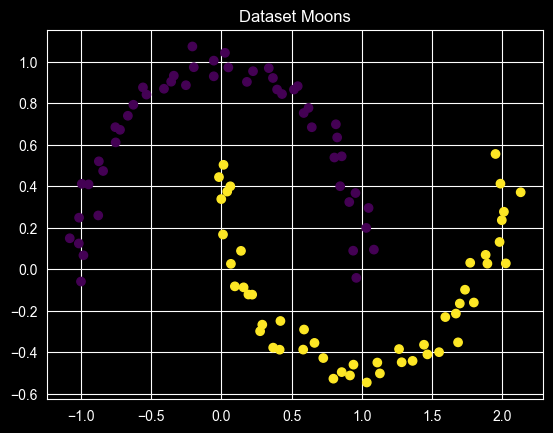

In [5]:
X, y = make_moons(n_samples=100, noise=0.05, random_state=42)
y[y == 0] = -1
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.title("Dataset Moons")
plt.show()

# Ponto importante para o dataset

- Para esse problema, principalmente com a utilização do angleembedding o MinMaxScaler de 0 a pi foi o maior diferencial, antes de o implementar o modelo não conseguia convergir pois o angle funciona melhor com dados ja em radianos, ao usar numeros normais ele entende isso como graus normais e isso acaba por limitar as rotações que ele consegue fazer

In [ ]:
scaler = MinMaxScaler(feature_range=(0, np.pi))
X = scaler.fit_transform(X)
y = y.astype(float)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.5, random_state=42
)

# Visualização do Circuito

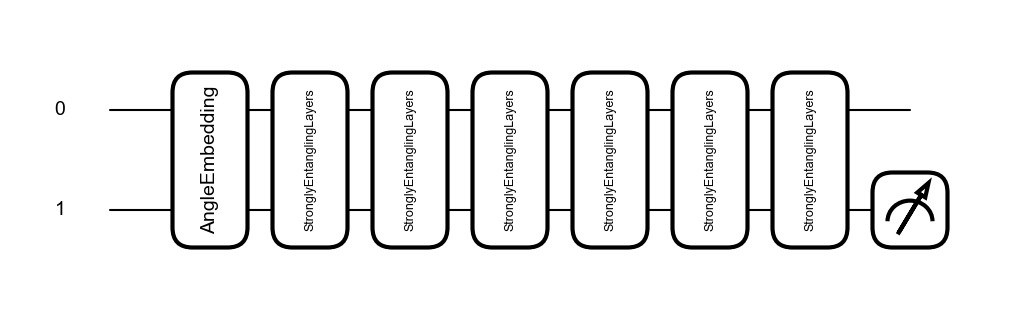

In [6]:
fig, ax = qml.draw_mpl(circuito)(weights_init, X)
plt.show()

# Treinamento
O treinamento foi usado as funções padrões que usei para os problemas. Com validação sendo feita com X_val e y_val

Treinando: 100%|██████████| 200/200 [16:50<00:00,  5.05s/it, acc=0.4000, loss=0.9918]


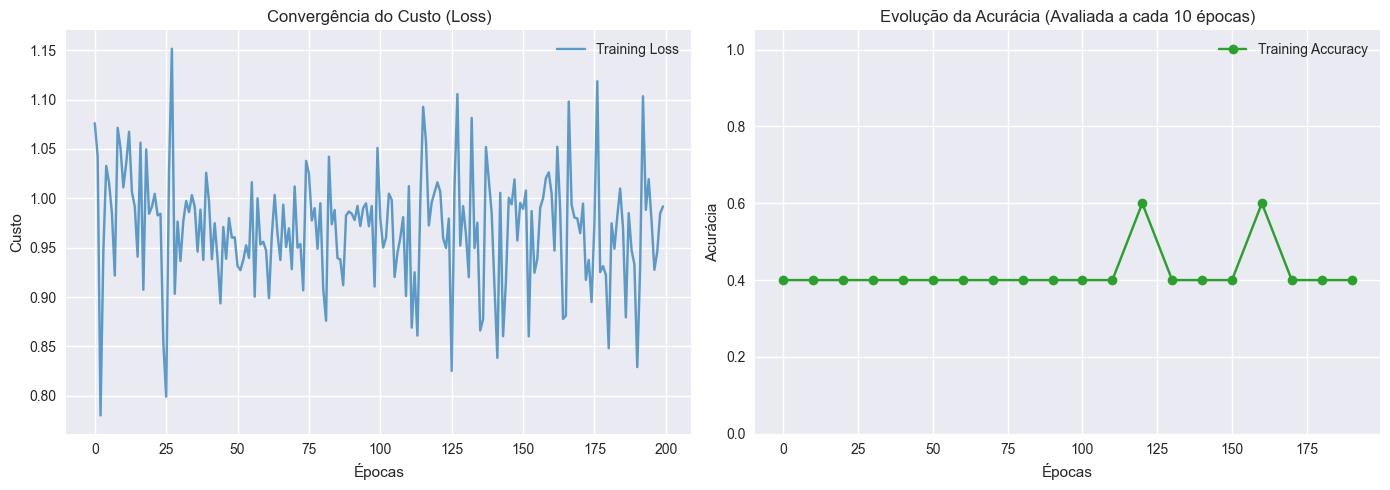

In [7]:
X_train = np.array(X_train, requires_grad=False)
y_train = np.array(y_train, requires_grad=False)
weights = np.array(weights_init, requires_grad=True)
bias = np.array(bias_init, requires_grad=True)

loss_history = []
acc_history = []
epochs_x = []

epochs = 200
batch_size = 80

pbar = tqdm(range(epochs), desc="Treinando")

last_acc = 0.0

for it in pbar:
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = y_train[batch_index]

    weights, bias = opt.step(cost, weights, bias, X=X_batch, y=Y_batch)

    current_cost = cost(weights, bias, X_batch, Y_batch)
    loss_history.append(float(current_cost))

    if it % 10 == 0:
        predictions = [np.sign(circuito(weights, x) + bias) for x in X_val]

        current_acc = accuracy(y_val, predictions)

        acc_history.append(current_acc)
        epochs_x.append(it)

        last_acc = current_acc

    pbar.set_postfix(loss=f"{current_cost:.4f}", acc=f"{last_acc:.4f}")

plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(epochs), loss_history, label='Training Loss', color='tab:blue', alpha=0.7)
ax1.set_title('Convergência do Custo (Loss)')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Custo')
ax1.grid(True)
ax1.legend()

ax2.plot(epochs_x, acc_history, label='Training Accuracy', color='tab:green', marker='o', linestyle='-')
ax2.set_title('Evolução da Acurácia (Avaliada a cada 10 épocas)')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Acurácia')
ax2.set_ylim(0, 1.05)  #
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()
res = 50


# Visualização da Fronteira do circuito
- Para esse problema em especifico, por usar o angleembedding foi preciso por o plano em coordenadas pi, se não fosse assim o modelo não conseguia desenhar muito bem no plano para visualização

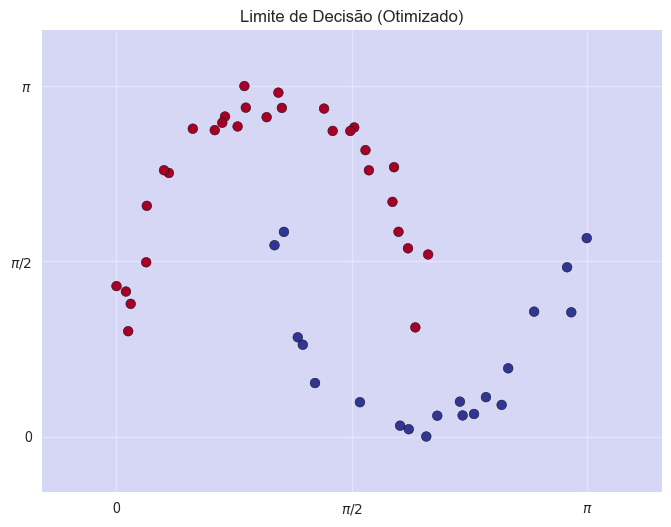

In [8]:
x_vals = np.linspace(X_val[:, 0].min() - 0.5, X_val[:, 0].max() + 0.5, res)
y_vals = np.linspace(X_val[:, 1].min() - 0.5, X_val[:, 1].max() + 0.5, res)
xx, yy = np.meshgrid(x_vals, y_vals)

grid_points = np    .c_[xx.ravel(), yy.ravel()]

Z = []
for x in grid_points:
    Z.append(circuito(weights, x) + bias)
Z = np.array(Z).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=[-np.inf, 0, np.inf], alpha=0.3, colors=['#ffaaaa', '#aaaaff'])
plt.contour(xx, yy, Z, levels=[0], colors='black', linestyles='--')

plt.xticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi], [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
plt.yticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi], [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])

plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=plt.cm.RdYlBu, edgecolor='k')
plt.title("Limite de Decisão (Otimizado)")
plt.show()